<h1 align="left">Using Autoencoders on MNIST Fashion Dataset</h1>

Source Code = https://github.com/Rahulraj31/Autoencoder_MNIST-Fashion/blob/main/MNIST_Autoencoders.ipynb

dataset = https://www.kaggle.com/zalando-research/fashionmnist

In [1]:
# check your gpu is available:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# for tensorflow instance:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8199489578255919769
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16154099712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10051106998085780214
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]
Found GPU at: /device:GPU:0


In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib import pyplot

from imgaug import augmenters
from random import randint

from tensorflow import keras
from tensorflow.keras import layers,losses
from tensorflow.keras.layers import Flatten,Dense, Input, Conv2D,MaxPool2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from numpy import argmax, array_equal

from tensorflow.keras.datasets import fashion_mnist, mnist

In [3]:
# read dataset
# https://keras.io/api/datasets/fashion_mnist/
#(train_x, train_y), (test_x, test_y) = mnist.load_data()
(train_x, train_y), (test_x, test_y) = fashion_mnist.load_data()
assert train_x.shape == (60000, 28, 28)
assert train_y.shape == (60000,)

assert test_x.shape == (10000, 28, 28)
assert test_y.shape == (10000,)

# train=pd.read_csv("/content/fashion-mnist_train.csv")
# train_x = train[list(train.columns[1:])].values
# train_y = train['label'].values

4431872/4422102 [==============================] - 0s 0us/step


# For Image Denoising

In [4]:
## create train and validation datasets
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, 
                                                  test_size=0.2,random_state=42)

# Normalize it 
train_x= train_x.astype(np.float32) / 255
val_x =val_x.astype(np.float32) /255
test_x =test_x.astype(np.float32) /255

In [5]:
#Reshaping data to specify channel for CNN
print(train_x.shape)
train_x = train_x.reshape(-1, 28, 28, 1)
print(train_x.shape)
val_x = val_x.reshape(-1, 28, 28, 1)
test_x = test_x.reshape(-1, 28, 28, 1)

(48000, 28, 28)
(48000, 28, 28, 1)


**Noisy Images**

We can intentionally introduce the noise in an image. I am using imaug package which can be used to augment the images with different variations. One such variation can be introduction of noise. Different types of noises can be added to the images. For example:

Salt and Pepper Noise

Gaussian Noise

Periodic Noise

Speckle Noise

Lets introduce salt and pepper noise to our data which is also known as impulse noise. This noise introduces sharp and sudden disturbances in the image signal. It presents itself as sparsely occurring white and black pixels.

In [6]:
# Lets add sample noise - Salt and Pepper
#noise = augmenters.AdditiveGaussianNoise(scale=0.1*255)
#noise = augmenters.AdditivePoissonNoise(lam=(15))
noise = augmenters.AdditiveLaplaceNoise(scale=0.1*255)
#noise = augmenters.SaltAndPepper(0.1)

seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x * 255) / 255
val_x_n = seq_object.augment_images(val_x * 255) / 255
test_x_n = seq_object.augment_images(test_x * 255) / 255

### Before adding noise

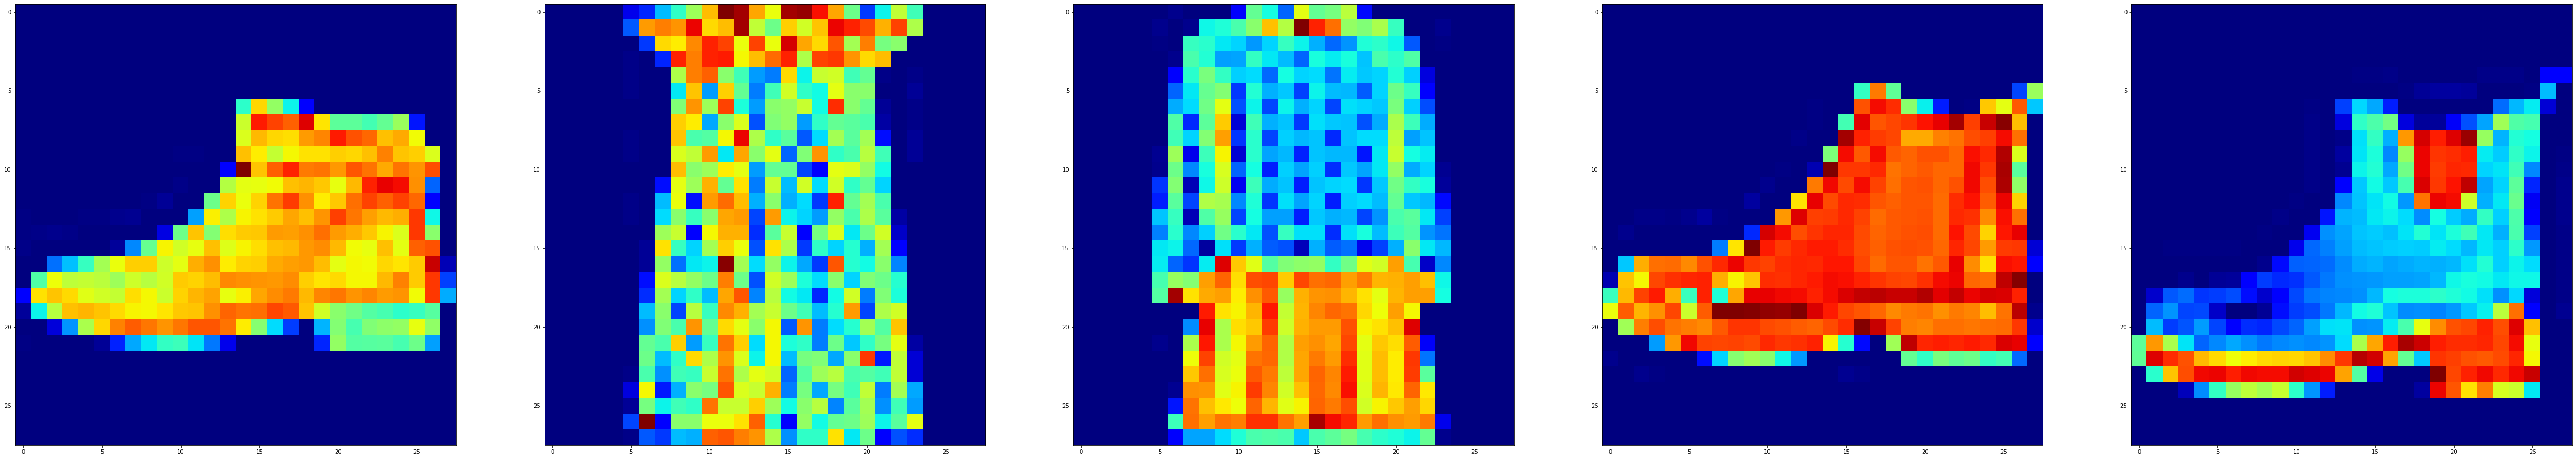

In [7]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x[i].reshape(28, 28), cmap='jet')
plt.show()

### After adding noise

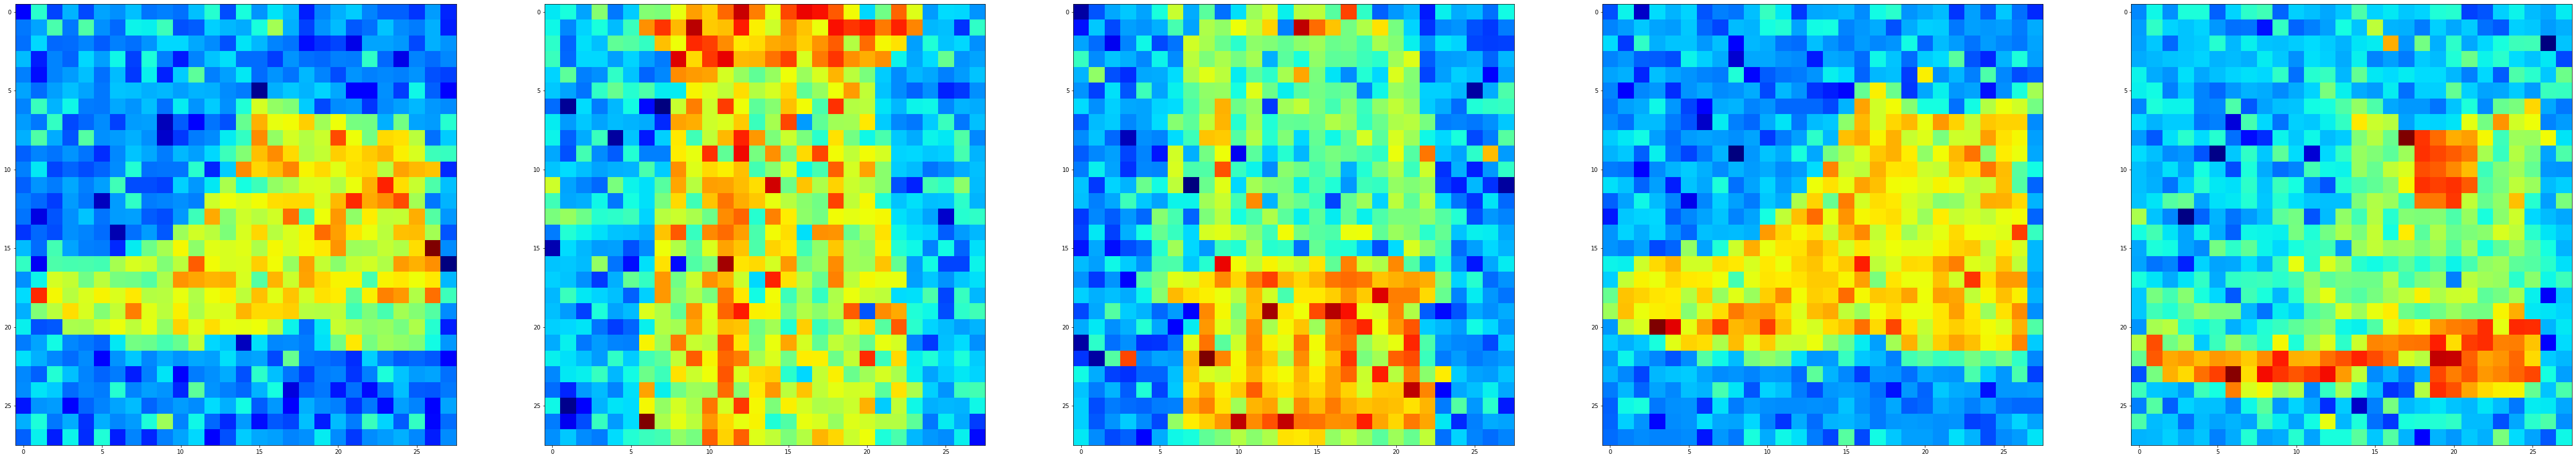

In [8]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i].reshape(28, 28), cmap='jet')
plt.show()

### Encoding Architecture:

The encoding architure is composed of 3 Convolutional Layers and 3 Max Pooling Layers stacked one by one. Relu is used as the activation function in the convolution layers and padding is kept as "same". Role of max pooling layer is to downsample the image dimentions. This layer applies a max filter to non-overlapping subregions of the initial representation.


### Decoding Architecture:

Similarly in decoding architecture, the convolution layers will be used having same dimentions (in reverse manner) as the encoding architecture. But instead of 3 maxpooling layers, we will be adding 3 upsampling layers. Again the activation function will be same (relu), and padding in convolution layers will be same as well. Role of upsampling layer is to upsample the dimentions of a input vector to a higher resolution / dimention. The max pooling operation is non-invertible, however an approximate inverse can be obtained by recording the locations of the maxima within each pooling region. Umsampling layers make use of this property to project the reconstructions from a low dimentional feature space.

In [9]:
# input layer 
input_layer = Input(shape=(28, 28, 1))

# Encoding Architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)

encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)

encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)

latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)

decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)

decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)


output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

#dimension of output layer == input layer coz we need denoised image thats why there is no dense layer only Conv layer 


In [10]:
# compile the model
model = Model(input_layer, output_layer)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['accuracy'])

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4624  

In [12]:
for layer in model.layers:
  if 'conv' not in layer.name:
    continue
  filters, biases = layer.get_weights()
  print(layer.name, filters.shape)

conv2d (3, 3, 1, 64)
conv2d_1 (3, 3, 64, 32)
conv2d_2 (3, 3, 32, 16)
conv2d_3 (3, 3, 16, 16)
conv2d_4 (3, 3, 16, 32)
conv2d_5 (3, 3, 32, 64)
conv2d_6 (3, 3, 64, 1)


In [13]:
# Training

# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0,
#                                patience=10, verbose=5, mode='auto')

# model_checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', save_freq=10)

history = model.fit(train_x_n, train_x, epochs=100, batch_size=480, validation_data=(val_x_n, val_x), callbacks=[])
model.save("model.h5")

Epoch 1/100
100/100 [==============================] - 13s 24ms/step - loss: 0.0558 - accuracy: 0.4984 - val_loss: 0.0302 - val_accuracy: 0.5029
Epoch 2/100
100/100 [==============================] - 2s 22ms/step - loss: 0.0262 - accuracy: 0.5040 - val_loss: 0.0238 - val_accuracy: 0.5049
Epoch 3/100
100/100 [==============================] - 2s 22ms/step - loss: 0.0225 - accuracy: 0.5052 - val_loss: 0.0214 - val_accuracy: 0.5055
Epoch 4/100
100/100 [==============================] - 2s 22ms/step - loss: 0.0207 - accuracy: 0.5058 - val_loss: 0.0199 - val_accuracy: 0.5059
Epoch 5/100
100/100 [==============================] - 2s 22ms/step - loss: 0.0194 - accuracy: 0.5062 - val_loss: 0.0191 - val_accuracy: 0.5067
Epoch 6/100
100/100 [==============================] - 2s 20ms/step - loss: 0.0185 - accuracy: 0.5064 - val_loss: 0.0182 - val_accuracy: 0.5064
Epoch 7/100
100/100 [==============================] - 2s 21ms/step - loss: 0.0179 - accuracy: 0.5067 - val_loss: 0.0176 - val_accuracy

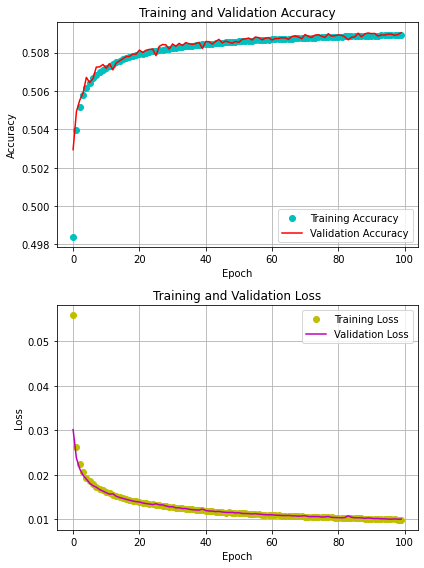

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
ax1.plot(epochs, acc, 'co', label='Training Accuracy')
ax1.plot(epochs, val_acc, 'r', label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.xaxis.grid(True)
ax1.yaxis.grid(True)
ax1.legend()

ax2.plot(epochs, loss, 'yo', label='Training Loss')
ax2.plot(epochs, val_loss, 'm', label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.xaxis.grid(True)
ax2.yaxis.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

In [15]:
model = keras.models.load_model("model.h5")

Increase epochs and tune it for better accuracy Lets obtain the predictions of the model

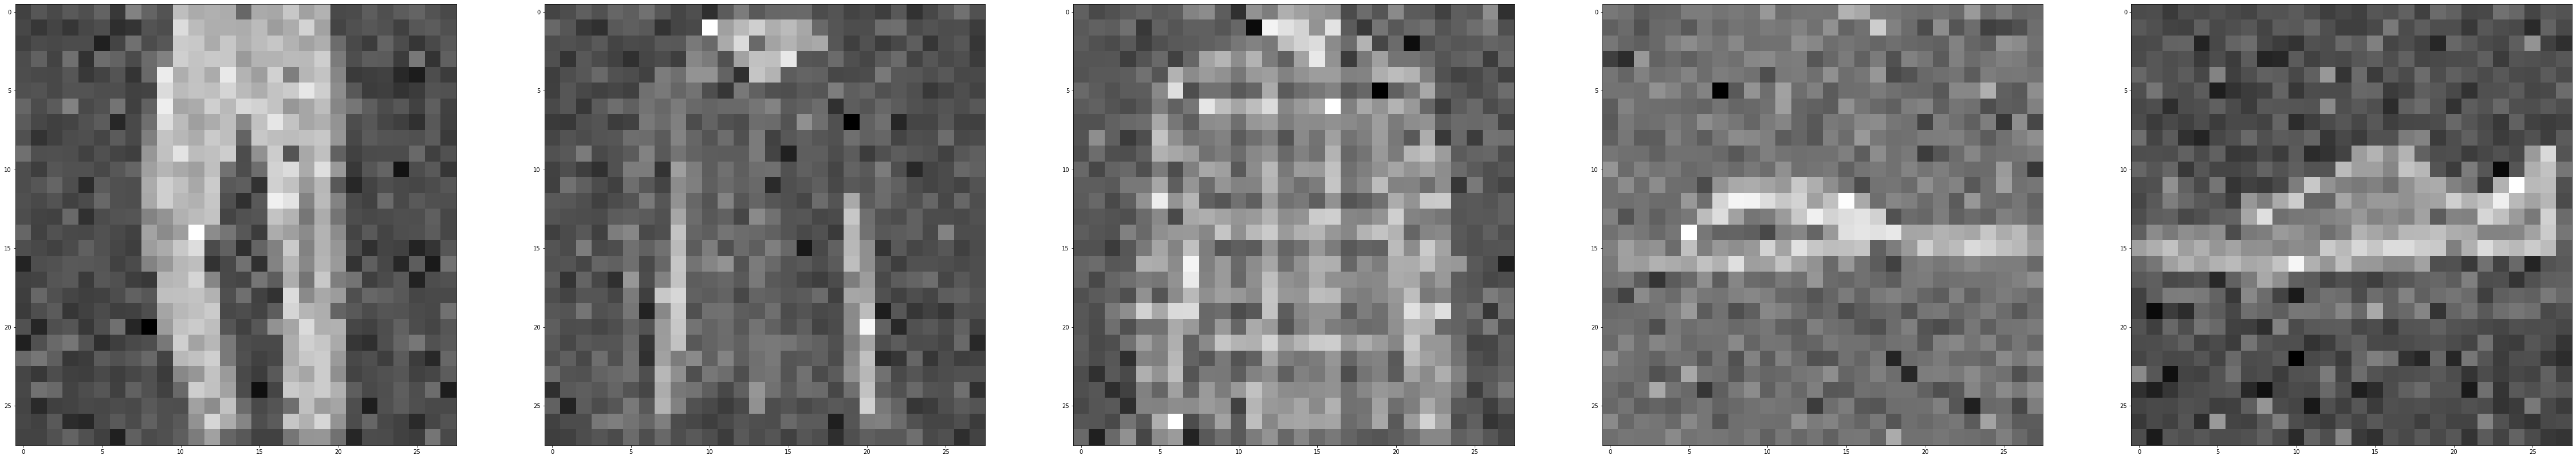

In [16]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(test_x_n[i].reshape(28, 28), cmap='gray')
plt.show()

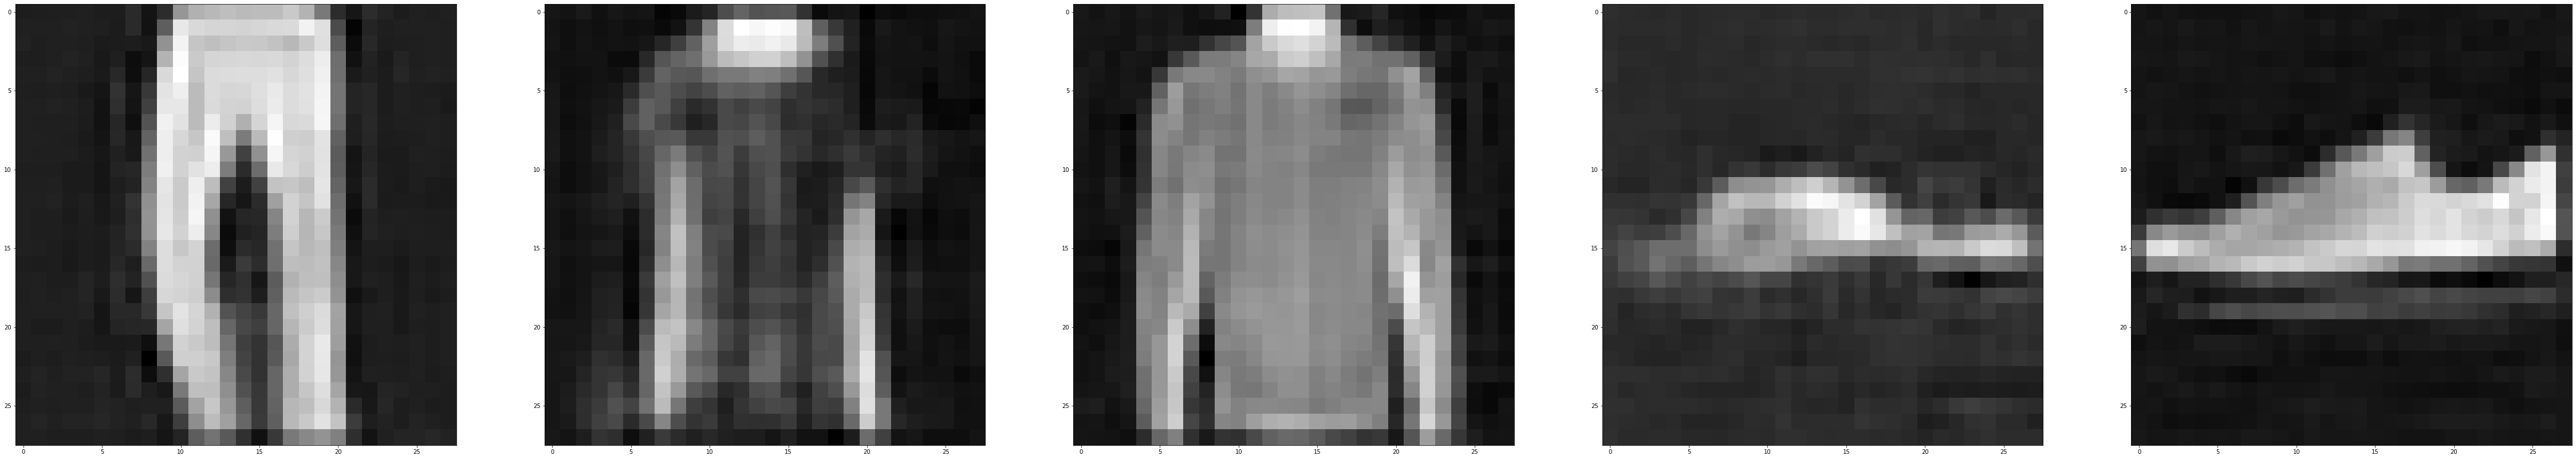

In [17]:
preds = model.predict(test_x_n[:10])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(preds[i].reshape(28, 28), cmap='gray')
plt.show()

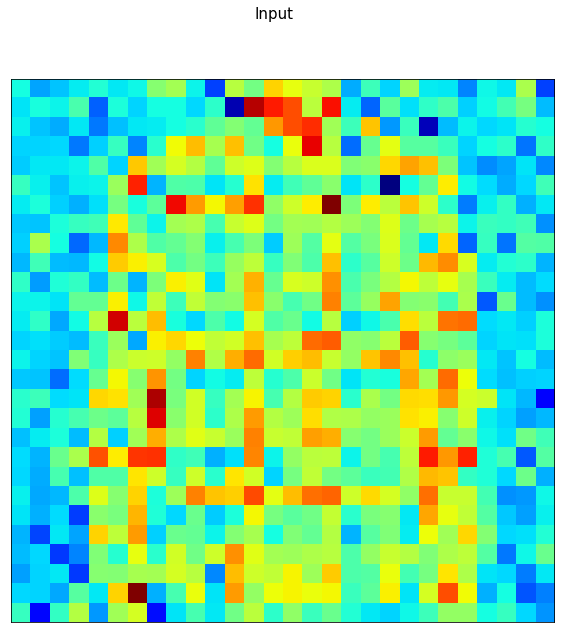

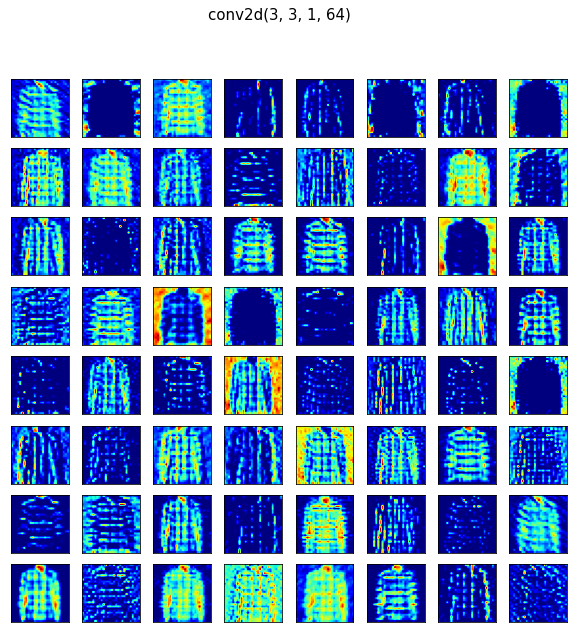

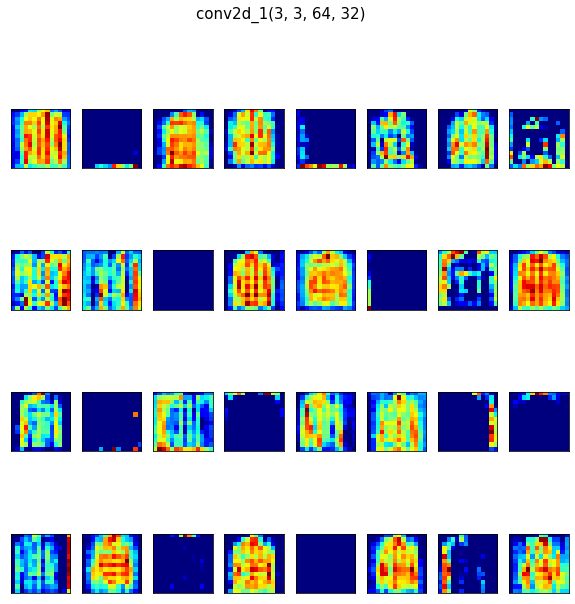

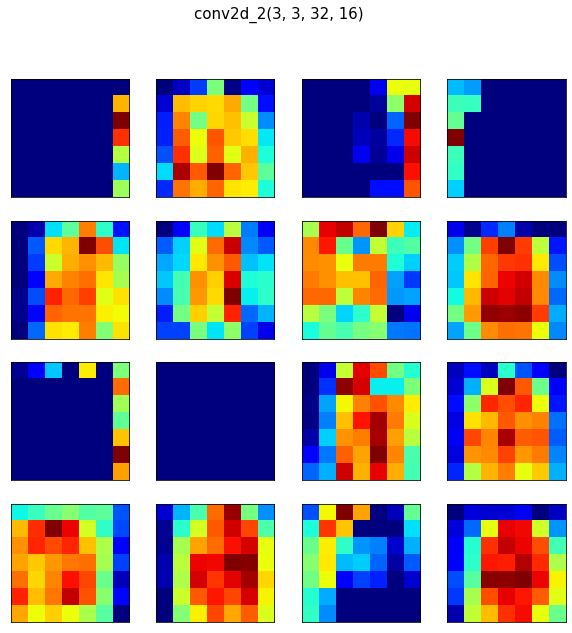

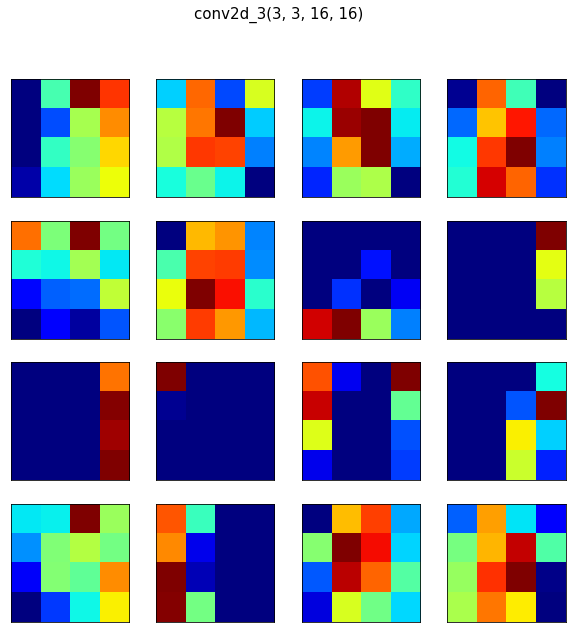

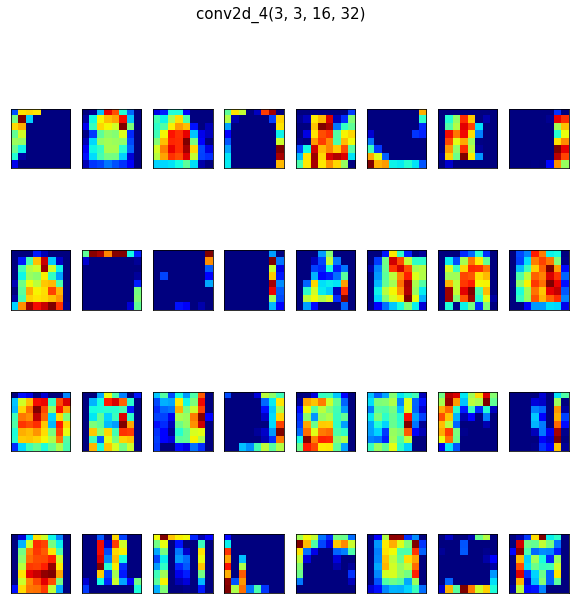

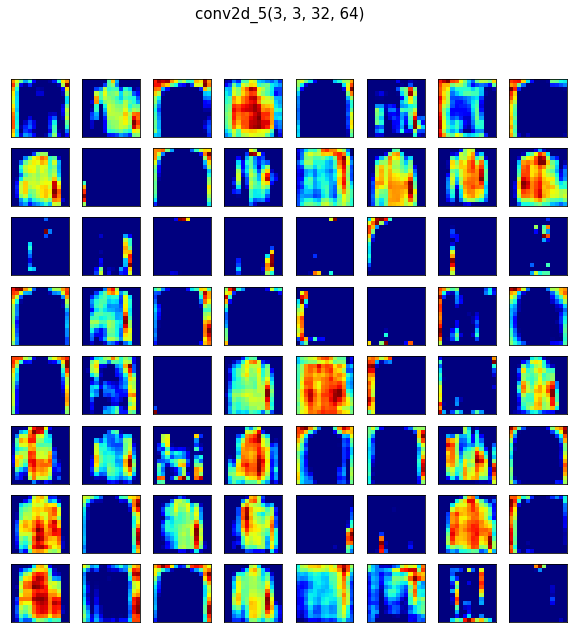

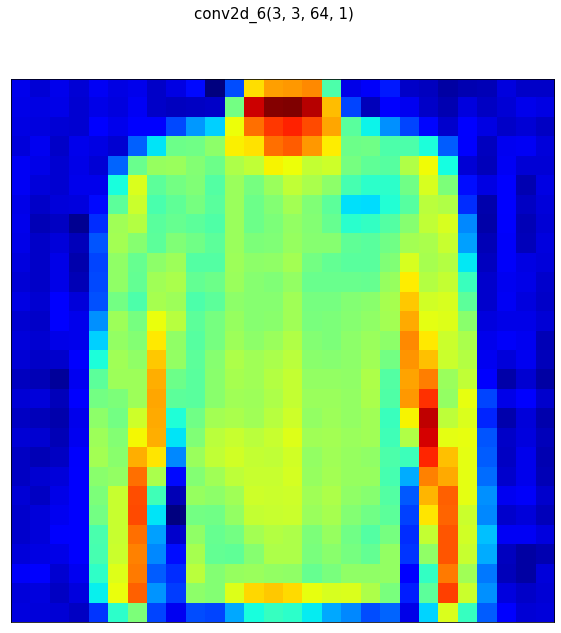

In [18]:
noised_image = test_x_n[7:8]

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 10)
fig.suptitle("Input", fontsize=15)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(noised_image.reshape(28, 28), cmap='jet')
plt.show()
print()

outputs=[]
for layer in model.layers:
  if 'conv' in layer.name:
    outputs.append(layer.output)

model = Model(inputs=model.inputs, outputs=outputs)
feature_maps = model.predict(noised_image)

fig_dim = [[8,8],[4,8],[4,4],[4,4],[4,8],[8,8],[1,1]]
layers=[]
for layer in model.layers:
  if 'conv' not in layer.name:
    continue
  layers.append(layer)

for dim, fmap, layer in zip(fig_dim, feature_maps, layers):
  filters, biases = layer.get_weights()
  row = dim[0]
  col = dim[1]
  fig = plt.figure(figsize=(10,10))
  fig.suptitle(str(layer.name)+str(filters.shape) , fontsize=15)
  ix = 1
  for _ in range(row):
    for _ in range(col):
      ax = fig.add_subplot(row, col, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      ax.imshow(fmap[0, :, :, ix-1], cmap='jet', alpha=1)
      ix += 1
  plt.show()
  print()